In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=3)

# NN dependencies
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# sk dependencies
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor

import scipy
from scipy import stats

import skopt
from skopt.space import Space
from skopt.sampler import Lhs

In [2]:
df = pd.read_csv('slump_test.data')
df

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82
...,...,...,...,...,...,...,...,...,...,...,...
98,99,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97
99,100,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23
100,101,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50
101,102,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17


In [ ]:
x_list = df.columns[1:8]
obj_list = ['SLUMP(cm)', 'Compressive Strength (28-day)(Mpa)']
train_X = df[x_list].to_numpy()
train_y = df[obj_list].to_numpy()

xscaler = MinMaxScaler()
transformed_X = xscaler.fit_transform(train_X)

yscaler = MinMaxScaler() # we use this because it is easier to optimize on compared to power transform
transformed_y = yscaler.fit_transform(train_y)

In [ ]:
target_dict = {'SL': 'SLUMP(cm)',
               'CS': 'Compressive Strength (28-day)(Mpa)',  
              }
    
X_dict = {}
X_hold_dict ={}
y_dict = {}
y_hold_dict = {}

for key, i in zip(target_dict.keys(), range(len(obj_list))):
    y_data = np.expand_dims(transformed_y[:,i], axis=1)
    
    X_dict[key], X_hold_dict[key], y_dict[key], y_hold_dict[key] = train_test_split(transformed_X,
                                                                                    y_data,
                                                                                    test_size = 0.2, random_state=1)
    
X_dict_torch = {}
X_hold_dict_torch = {}
y_dict_torch = {}
y_hold_dict_torch = {}

for key in target_dict.keys():
    X_dict_torch[key] = Variable(torch.tensor(X_dict[key].astype('float32'), device=device))
    X_hold_dict_torch[key] = Variable(torch.tensor(X_hold_dict[key].astype('float32'), device=device))
    
    y_dict_torch[key] = Variable(torch.tensor(y_dict[key].astype('float32'), device=device))
    y_hold_dict_torch[key] = Variable(torch.tensor(y_hold_dict[key].astype('float32'), device=device))

In [ ]:
class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, n_hidden_nodes):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.predict = nn.Linear(n_hidden_nodes, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, epochs=100):

        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()
      
        for t in range(epochs):

            pred = self.forward(x)     
            loss = loss_func(pred, y)
            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step() # update gradient

## generate models

models_tdict = {}
n_models = 10
n_input_nodes = len(x_list)

print('Compiling models')

for key in target_dict.keys():
    print(key)

    X_train = X_dict_torch[key]
    y_train = y_dict_torch[key]
    
    for i in range(n_models):
            torch.manual_seed(i)

            model = Net(n_input_nodes=n_input_nodes, 
                        n_hidden_layers=10, 
                        n_hidden_nodes=100)

            model.to(device)

            model.fit(X_train, y_train, epochs = 500)  
                
            models_tdict['{:}_{:}'.format(key, i)] = model            

            print('   model {:}{:} trained'.format(key, i+1))
            
df_dict_torch = {}

for key in target_dict.keys():

    X_train = X_dict_torch[key]
    y_train = y_dict_torch[key]

    X_test = X_hold_dict_torch[key]
    y_test = y_hold_dict_torch[key]

    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for s, d, X in zip(['train', 'test'], [df_train, df_test], [X_train, X_test]):
        for i in range(n_models):
            m = models_tdict['{:}_{:}'.format(key, i)]
            m.eval()
            y_pred = m.forward(X)
            
            d[i] = y_pred.cpu().data.numpy().flatten()
    
        d['{:}-mean'.format(s)] = d.iloc[:,:n_models].mean(axis=1) # takes the mean prediction across all models in ensemble
        d['{:}-std'.format(s)] = d.iloc[:,:n_models].std(axis=1)
        df_dict_torch[key+'_{:}'.format(s)] = d
        
fig, axis = plt.subplots(ncols = 2, figsize = (12,8))

for key, ax in zip(target_dict.keys(), axis.ravel()):
    y_true = y_dict[key]
    y_test = y_hold_dict[key]

    #for i in range(n_models):
    #    y_pred = df_dict_torch[key+'_train'][i]    
    #    ax.errorbar(x=y_true, y=y_pred, ls='', marker='o', mec='w', mew=0.5, alpha =0.2)
        
    ax.axline((1, 1), slope=1)

    for s, y_set, c in zip(['train', 'test'], [y_true, y_test], ['r', 'b']):
        
        y_pred = df_dict_torch[key+'_'+s][s+'-mean']
        yerr = df_dict_torch[key+'_'+s][s+'-std']
        
        r2 = metrics.r2_score(y_set, y_pred)
        ax.errorbar(x=y_set, y=y_pred, yerr=yerr, ls='', 
                    marker='D', mec='w', mew=0.8, mfc=c, c=c, 
                    label='{:} R$^2$={:.3f}'.format(s,r2)
                   )
    ax.set_title(key)
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')
    
axis[0].set_ylabel('Predicted Value')
fig.suptitle('PyTorch Ensemble')
fig.tight_layout()

In [ ]:
## generate models

rf_dict = {}

print('Compiling RF regressors')

for key in target_dict.keys():
    print(key)

    X_train = X_dict[key]
    y_train = y_dict[key]
    
    rf = RandomForestRegressor(random_state=1).fit(X_train, y_train.ravel())
    rf_dict['{:}'.format(key)] = rf
    print('   model {:} trained'.format(key))
    
df_dict = {}

for key in target_dict.keys():

    X_train = X_dict[key]
    y_train = y_dict[key]

    X_test = X_hold_dict[key]
    y_test = y_hold_dict[key]

    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for s, d, X in zip(['train', 'test'], [df_train, df_test], [X_train, X_test]):
        m = rf_dict['{:}'.format(key)]
        y_pred = m.predict(X)
    
        d['{:}-mean'.format(s)] = y_pred.flatten()
        df_dict[key+'_{:}'.format(s)] = d
        
fig, axis = plt.subplots(ncols = 2, figsize = (12,8))

for key, ax in zip(target_dict.keys(), axis.ravel()):
    y_true = y_dict[key]
    y_test = y_hold_dict[key]
    y_pred = df_dict[key+'_train']

    ax.axline((1, 1), slope=1)

    for s, y_set, c in zip(['train', 'test'], [y_true, y_test], ['r', 'b']):
        
        y_pred = df_dict[key+'_'+s][s+'-mean']
        
        r2 = metrics.r2_score(y_set, y_pred)
        ax.scatter(x=y_set, y=y_pred, #yerr=yerr, ls='', 
                    marker='D', c=c, 
                    label='{:} R$^2$={:.3f}'.format(s,r2)
                   )
    ax.set_title(key)
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')
    ax.grid()
    
axis[0].set_ylabel('Predicted Value')
fig.suptitle('sklearn RF Regressor')
fig.tight_layout()

In [ ]:
## generate models

gp_dict = {}

print('Compiling GP regressors')

for key in target_dict.keys():
    print(key)

    X_train = X_dict[key]
    y_train = y_dict[key]
    
    kernel = ConstantKernel(1.0, constant_value_bounds='fixed') * Matern(nu=2.5) + WhiteKernel(noise_level=1)
    
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=1, n_restarts_optimizer=10).fit(X_train, y_train)
    gp_dict['{:}'.format(key)] = gpr
    print('   model {:} trained'.format(key))
    
df_dict = {}

for key in target_dict.keys():

    X_train = X_dict[key]
    y_train = y_dict[key]

    X_test = X_hold_dict[key]
    y_test = y_hold_dict[key]

    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for s, d, X in zip(['train', 'test'], [df_train, df_test], [X_train, X_test]):
        m = gp_dict['{:}'.format(key)]
        y_pred, std = m.predict(X, return_std=True)
    
        d['{:}-mean'.format(s)] = y_pred.flatten()
        d['{:}-std'.format(s)] = std
        df_dict[key+'_{:}'.format(s)] = d
        
fig, axis = plt.subplots(ncols = 2, figsize = (12,8))

for key, ax in zip(target_dict.keys(), axis.ravel()):
    y_true = y_dict[key]
    y_test = y_hold_dict[key]
    y_pred = df_dict[key+'_train']
    
    ''' 
    ax.errorbar(x=y_true, y=y_pred, ls='', marker='o', mec='w', 
                mew=0.5, alpha =0.2)
    '''

    ax.axline((1, 1), slope=1)

    for s, y_set, c in zip(['train', 'test'], [y_true, y_test], ['r', 'b']):
        
        y_pred = df_dict[key+'_'+s][s+'-mean']
        yerr = df_dict[key+'_'+s][s+'-std']
        
        r2 = metrics.r2_score(y_set, y_pred)
        ax.errorbar(x=y_set, y=y_pred, yerr=yerr, ls='', 
                    marker='D', mec='w', mew=0.8, mfc=c, c=c, 
                    label='{:} R$^2$={:.3f}'.format(s,r2)
                   )
    ax.set_title(key)
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')
    
axis[0].set_ylabel('Predicted Value')
fig.suptitle('sklearn GP Regressor')
fig.tight_layout()

In [3]:
target_dict = {'SL': 'SLUMP(cm)',
               'CS': 'Compressive Strength (28-day)(Mpa)',  
              }
    
x_list = df.columns[1:8]
obj_list = ['SLUMP(cm)', 'Compressive Strength (28-day)(Mpa)']
train_X = df[x_list].to_numpy()
train_y = df[obj_list].to_numpy()

xscaler = MinMaxScaler()
transformed_X = xscaler.fit_transform(train_X)

yscaler = MinMaxScaler() # we use this because it is easier to optimize on compared to power transform
transformed_y = yscaler.fit_transform(train_y)    

#transformed_X = train_X
#transformed_y = train_y
    
X_dict = {}
y_dict = {}

for key, i in zip(target_dict.keys(), range(len(obj_list))):
    
    X_dict[key] = transformed_X
    y_dict[key] = np.expand_dims(transformed_y[:,i], axis=1)
    
X_dict_torch = {}
y_dict_torch = {}

for key in target_dict.keys():
    X_dict_torch[key] = Variable(torch.tensor(X_dict[key].astype('float32'), device=device))
    y_dict_torch[key] = Variable(torch.tensor(y_dict[key].astype('float32'), device=device))


In [4]:
class Net(nn.Module):
    def __init__(self,n_input_nodes, n_hidden_layers, n_hidden_nodes):
        """
        n_feature : number of input feature nodes
        n_hidden : number of nodes in the hidden layer
        n_output : number of nodes in the output layer
        
        d_hidden : number of hidden layers
        """
        
        super(Net, self).__init__() ## inherit init function from the ancestor
        
        self.input = nn.Linear(n_input_nodes, n_hidden_nodes)
        self.hidden = nn.Linear(n_hidden_nodes, n_hidden_nodes)
        self.predict = nn.Linear(n_hidden_nodes, 1)
        
        self.l_hidden = n_hidden_layers
        
    def forward(self, x):
        x = self.input(x)
        
        for i in range(self.l_hidden):
            x = self.hidden(x)
            x = F.relu(x)
        x = self.predict(x)
        
        return x
    
    def fit(self, x, y, epochs=100):

        optimizer = torch.optim.Adam(self.parameters()) ## SGD gave 'nan'
        loss_func = nn.MSELoss()
      
        for t in range(epochs):

            pred = self.forward(x)     
            loss = loss_func(pred, y)
            optimizer.zero_grad()
            loss.backward()  # backpropagation
            optimizer.step() # update gradient

## generate models

models_tdict = {}
n_models = 10
n_input_nodes = len(x_list)

print('Compiling models')

for key in target_dict.keys():
    print(key)

    X_train = X_dict_torch[key]
    y_train = y_dict_torch[key]
    
    for i in range(n_models):
            torch.manual_seed(i)

            model = Net(n_input_nodes=n_input_nodes, 
                        n_hidden_layers=10, 
                        n_hidden_nodes=100)

            model.to(device)

            model.fit(X_train, y_train, epochs = 500)  
                
            models_tdict['{:}_{:}'.format(key, i)] = model            

            print('   model {:}{:} trained'.format(key, i+1))
            
df_dict_torch = {}

for key in target_dict.keys():

    X_train = X_dict_torch[key]
    y_train = y_dict_torch[key]

    d = pd.DataFrame()
    for i in range(n_models):
        m = models_tdict['{:}_{:}'.format(key, i)]
        m.eval()
        y_pred = m.forward(X_train)

        d[i] = y_pred.cpu().data.numpy().flatten()
    
    d['mean'] = d.iloc[:,:n_models].mean(axis=1) # takes the mean prediction across all models in ensemble
    d['std'] = d.iloc[:,:n_models].std(axis=1)
    df_dict_torch[key] = d

Compiling models
SL
   model SL1 trained
   model SL2 trained
   model SL3 trained
   model SL4 trained
   model SL5 trained
   model SL6 trained
   model SL7 trained
   model SL8 trained
   model SL9 trained
   model SL10 trained
CS
   model CS1 trained
   model CS2 trained
   model CS3 trained
   model CS4 trained
   model CS5 trained
   model CS6 trained
   model CS7 trained
   model CS8 trained
   model CS9 trained
   model CS10 trained


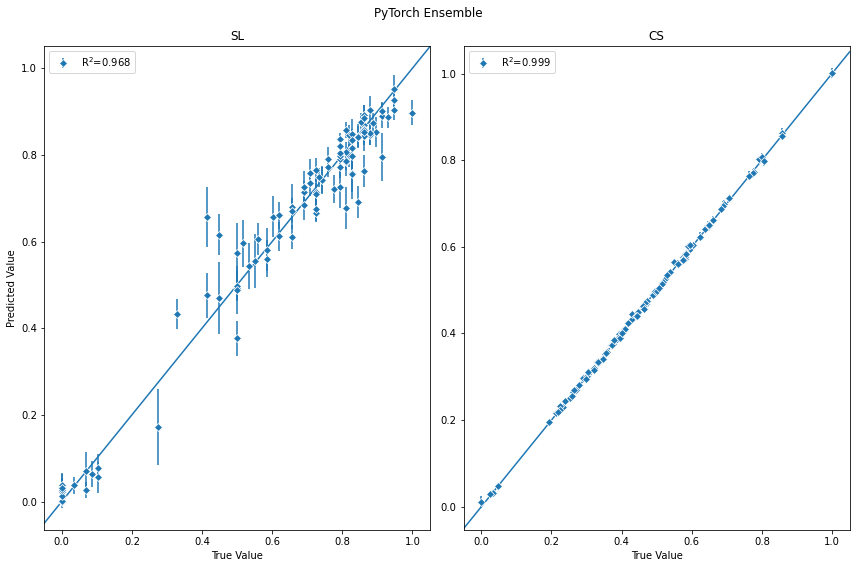

In [5]:
fig, axis = plt.subplots(ncols = 2, figsize = (12,8))

for key, ax in zip(target_dict.keys(), axis.ravel()):
    y_true = y_dict[key]
    y_pred = df_dict_torch[key]['mean']
    yerr = df_dict_torch[key]['std']

    ax.axline((1, 1), slope=1)
        
    r2 = metrics.r2_score(y_true, y_pred)
    ax.errorbar(x=y_true, y=y_pred, yerr=yerr, ls='', 
                marker='D', mec='w', mew=0.8,# mfc=c, c=c, 
                label='R$^2$={:.3f}'.format(r2)
               )
    ax.set_title(key)
    ax.set_xlabel('True Value')
    ax.legend(loc='upper left')
    
axis[0].set_ylabel('Predicted Value')
fig.suptitle('PyTorch Ensemble')
fig.tight_layout()

In [6]:
joblib.dump(models_tdict, 'models_tdict')
joblib.dump(xscaler, 'xscaler')
joblib.dump(yscaler, 'yscaler')

['yscaler']